Epoch 1/50
4/4 - 6s - loss: 0.0881 - mae: 0.2034 - val_loss: 0.0873 - val_mae: 0.2243 - 6s/epoch - 2s/step
Epoch 2/50
4/4 - 0s - loss: 0.0353 - mae: 0.1264 - val_loss: 0.0648 - val_mae: 0.1868 - 198ms/epoch - 49ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0311 - mae: 0.1266 - val_loss: 0.0639 - val_mae: 0.1947 - 175ms/epoch - 44ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0289 - mae: 0.1244 - val_loss: 0.0572 - val_mae: 0.1755 - 141ms/epoch - 35ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0229 - mae: 0.1035 - val_loss: 0.0593 - val_mae: 0.1791 - 143ms/epoch - 36ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0223 - mae: 0.0963 - val_loss: 0.0626 - val_mae: 0.1848 - 133ms/epoch - 33ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0217 - mae: 0.0940 - val_loss: 0.0617 - val_mae: 0.1795 - 176ms/epoch - 44ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0213 - mae: 0.0909 - val_loss: 0.0600 - val_mae: 0.1751 - 165ms/epoch - 41ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0194 - mae: 0.0879 - val_loss: 0.0601 - val_mae: 0.1790 - 176ms/epoch - 44ms/st

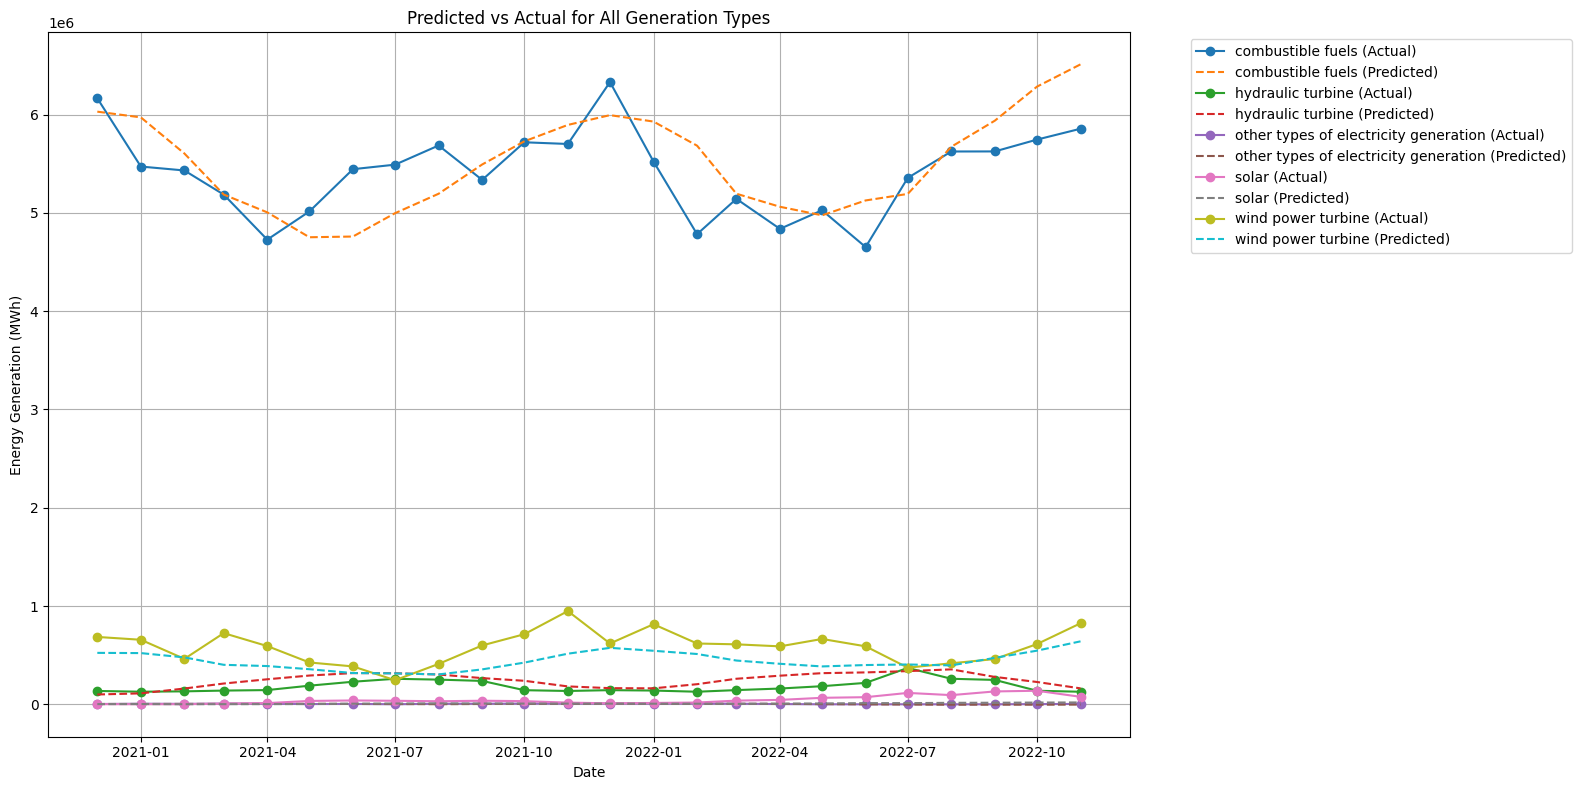

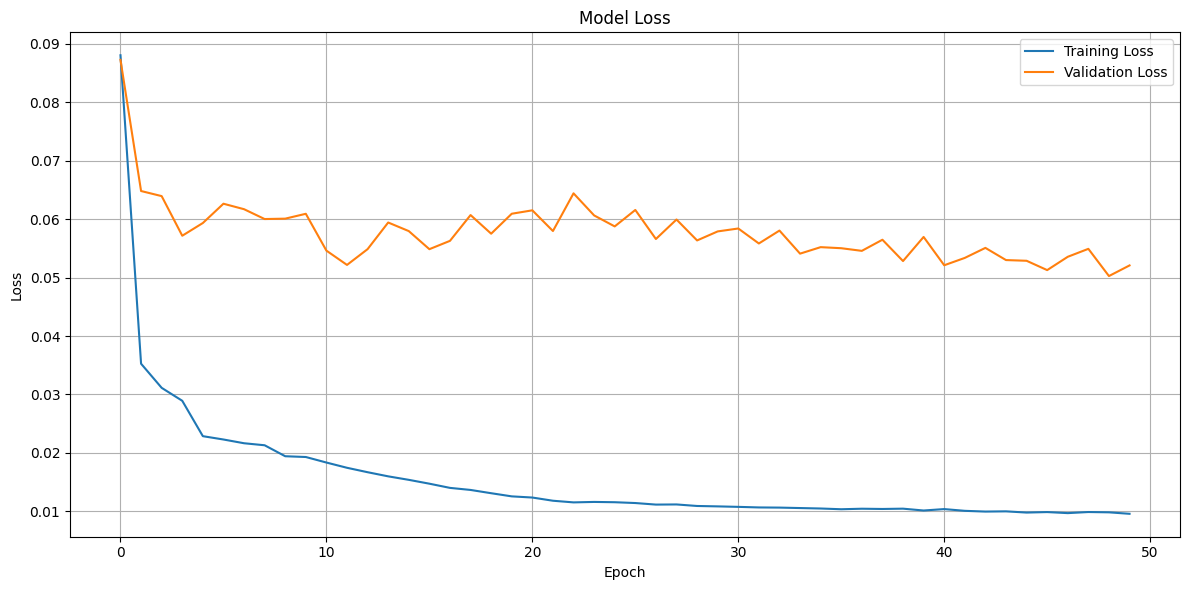

Epoch 1/50
5/5 - 0s - loss: 0.0159 - mae: 0.0818 - 124ms/epoch - 25ms/step
Epoch 2/50
5/5 - 0s - loss: 0.0132 - mae: 0.0816 - 139ms/epoch - 28ms/step
Epoch 3/50
5/5 - 0s - loss: 0.0123 - mae: 0.0797 - 160ms/epoch - 32ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0116 - mae: 0.0770 - 174ms/epoch - 35ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0111 - mae: 0.0739 - 160ms/epoch - 32ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0108 - mae: 0.0729 - 129ms/epoch - 26ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0108 - mae: 0.0731 - 171ms/epoch - 34ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0109 - mae: 0.0719 - 173ms/epoch - 35ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0107 - mae: 0.0703 - 160ms/epoch - 32ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0108 - mae: 0.0705 - 133ms/epoch - 27ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0106 - mae: 0.0710 - 139ms/epoch - 28ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0102 - mae: 0.0689 - 163ms/epoch - 33ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0101 - mae: 0.0676 - 149ms/epoch - 30ms/step
Epoch 14/50
5/5 - 0s 

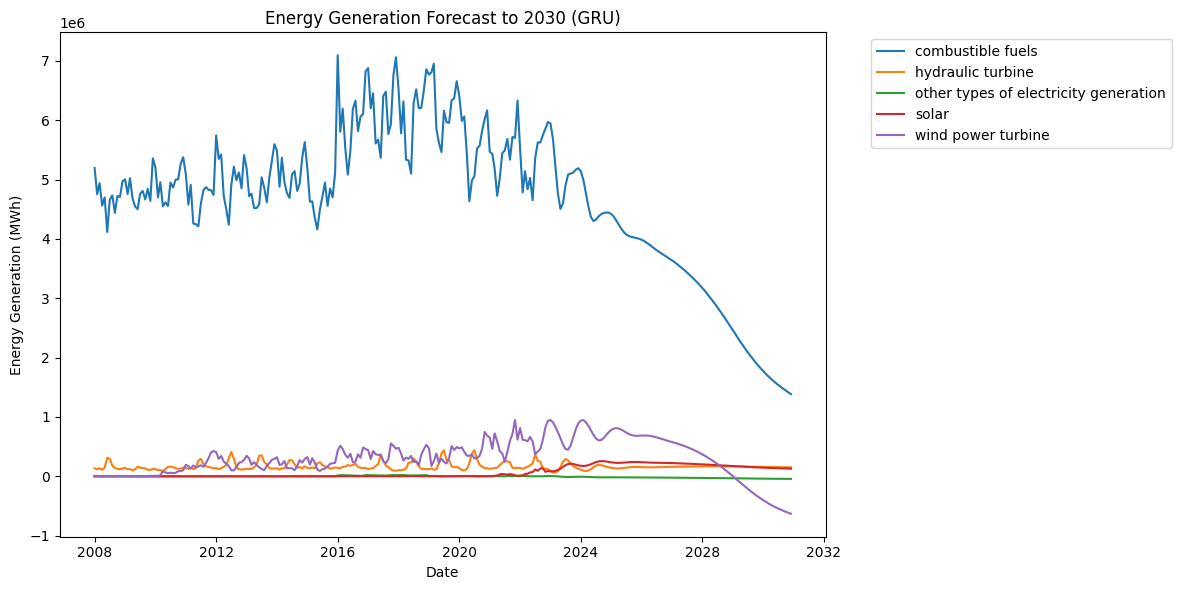

In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models

# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

# Ensure all generation types are represented for every date
def standardize_generation_types(df, unique_types):
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

# Scale the data
def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Create input-output sequences for time-series data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Build a GRU model
def build_gru(input_shape, output_shape):
    model = models.Sequential()
    model.add(layers.GRU(80, return_sequences=True, input_shape=input_shape))
    model.add(layers.GRU(40, return_sequences=False))
    model.add(layers.Dense(output_shape))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Plot forecasted values
def plot_forecasts(df_pivot, forecast_df, title):
    combined = pd.concat([df_pivot, forecast_df])
    plt.figure(figsize=(12, 6))
    for column in df_pivot.columns:
        plt.plot(combined.index, combined[column], label=column)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Energy Generation (MWh)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Forecast future energy generation
def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

# Main Script
filepath = r'data\processed\alberta_energy.csv'

# Load and process data
df_grouped = load_and_preprocess_data(filepath)
unique_generation_types = df_grouped['generation_type'].unique()
df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

df_pivot[df_pivot < 0] = 0  # Replace negative values with 0

# Scale the pivoted data
data_scaled, scaler = scale_data(df_pivot)

# Define the number of time steps (look-back period)
n_steps = 36

# Create sequences for training and testing
X, y = create_sequences(data_scaled, n_steps)
test_size = 24  # Assuming monthly data, 24 months = 2 years
train_data, test_data = data_scaled[:-test_size], data_scaled[-test_size - n_steps:]
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

# Define input and output shapes
input_shape = (n_steps, X_train.shape[2])
output_shape = y_train.shape[1]

# Build and compile the GRU model
gru_model = build_gru(input_shape, output_shape)

# Train the model
history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)

# Predict on the test set
y_pred_test = gru_model.predict(X_test)

# Rescale predictions and actual values back to their original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)

# Align the lengths for comparison
test_dates = df_pivot.index[-test_size:]
min_length = min(len(test_dates), len(y_test_rescaled), len(y_pred_test_rescaled))
test_dates = test_dates[:min_length]
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_test_rescaled = y_pred_test_rescaled[:min_length]

# Convert to DataFrame for easier handling
comparison_df = pd.DataFrame(data=y_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")
predicted_df = pd.DataFrame(data=y_pred_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")

# Combine actual and predicted values into a single DataFrame for plotting
combined_df = pd.concat([comparison_df.add_suffix(' (Actual)'), predicted_df.add_suffix(' (Predicted')], axis=1)

# Plot all generation types on the same figure
plt.figure(figsize=(16, 8))
for generation_type in df_pivot.columns:
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Actual)'], label=f'{generation_type} (Actual)', marker='o')
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Predicted'], label=f'{generation_type} (Predicted)', linestyle='--')

plt.title("Predicted vs Actual for All Generation Types")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

# Plot the loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Retrain the model on the entire dataset
X_full, y_full = create_sequences(data_scaled, n_steps)
gru_model.fit(X_full, y_full, epochs=50, batch_size=32, verbose=2)

# Forecast future values
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')
forecast_df_gru = forecast_future(gru_model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

# Plot the forecast
plot_forecasts(df_pivot, forecast_df_gru, "Energy Generation Forecast to 2030 (GRU)")


